Skibidi dop dop dop yes yes

In [169]:
# Import packages

import os, json

import matplotlib.pyplot as plt
import cv2 as cv

from sklearn import metrics, model_selection
import pandas as pd
import numpy as np
import cupy as cp
from xgboost import XGBClassifier

In [170]:
np.random.seed(42)

In [171]:
# DEVICE = "cpu"
DEVICE = "cuda"

# Data Preparation and Exploration

In [172]:
# Paths

MAPPING_PATH = 'data/shipsnet.json'

In [173]:
# Label mapping

ID2LABEL = {
    0: "NO_SHIP",
    1: "SHIP"
}

LABEL2ID = {
    "NO_SHIP": 0,
    "SHIP": 1,
}

In [174]:
# Loading mapping data

with open(MAPPING_PATH) as map_file:
    map_data = json.load(map_file)

df_data = pd.DataFrame(map_data)
df_data.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


<Axes: title={'center': 'Label Distribution'}, xlabel='labels'>

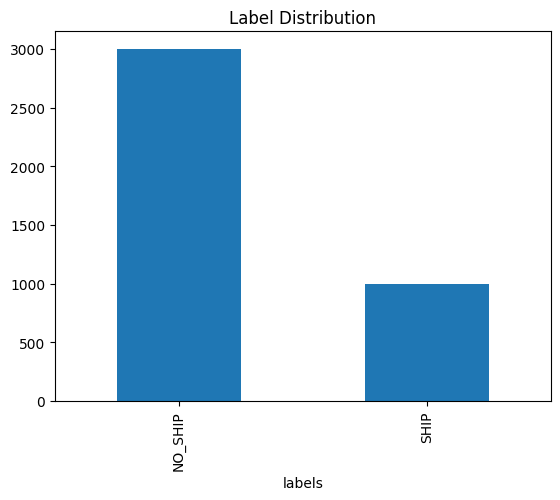

In [175]:
# Explore data

df_data["labels"].apply(lambda x: ID2LABEL[x]).value_counts().plot(kind="bar", title="Label Distribution")

**Note:** NO_SHIP dibagi lagi jadi land, partial_ship, dan hard

Pembagian indexingnya:
<br />
`SHIP` = 0-999
<br />
`NO_SHIP.land` = 1000 - 1999
<br />
`NO_SHIP.partial_ship` = 2000 - 2999
<br />
`NO_SHIP.hard` = 3000 - 3999

Total: 4000 data

**NB:** `locations` dan `scene_ids` will be ommited.

In [176]:
# Extract and reshape data

num_examples = len(df_data["data"])
len_data = len(df_data["data"][0])

X = np.zeros((num_examples, len_data), dtype="uint8")

for idx in range(num_examples):
    X[idx,:] = np.array(df_data["data"][idx]).astype(dtype="uint8")

X = X.reshape(-1, 3, 80, 80).transpose([0, 2, 3, 1])

X.shape

(4000, 80, 80, 3)

**Label Splittting Strategy:**
<br />
`SHIP` = 0
<br />
`NO_SHIP.land` = 1
<br />
`NO_SHIP.partial_ship` = 2
<br />
`NO_SHIP.hard` = 3

In [177]:
# New label mapping

ID2LABEL = {
    0: "SHIP",
    1: "NS.LAND",
    2: "NS.PS",
    3: "NS.HARD"
}

LABEL2ID = {
    "SHIP": 0,
    "NS.LAND": 1,
    "NS.PS": 2,
    "NS.HARD": 3,
}

In [178]:
# Splitting label

y = df_data["labels"].copy()
y[df_data.index[df_data["labels"] == 1]] = 0             # SHIP
y[df_data.index[df_data["labels"] == 0][:1000]] = 1      # NS.LAND
y[df_data.index[df_data["labels"] == 0][1000:2000]] = 2  # NS.PARTIAL_SHIP
y[df_data.index[df_data["labels"] == 0][2000:3000]] = 3  # NS.HARD
y.value_counts()

labels
0    1000
1    1000
2    1000
3    1000
Name: count, dtype: int64

<Axes: title={'center': 'Label Distribution'}, xlabel='labels'>

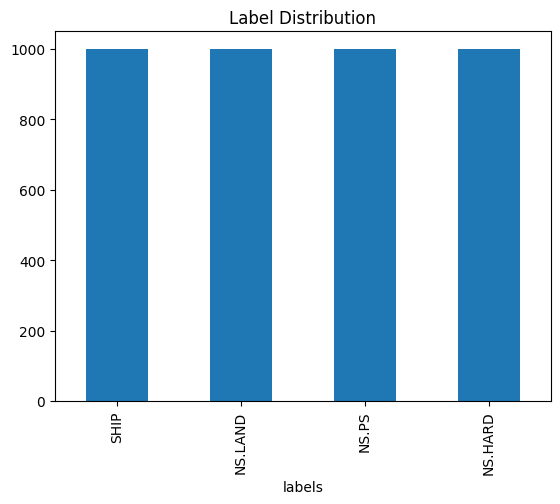

In [179]:
# Explore split data

y.apply(lambda y: ID2LABEL[y]).value_counts().plot(kind="bar", title="Label Distribution")

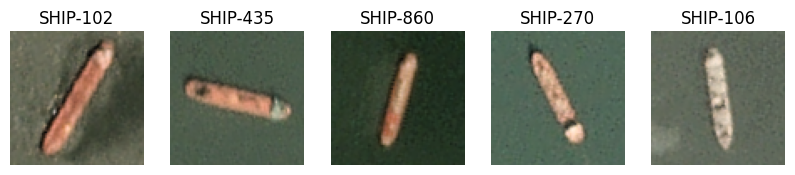

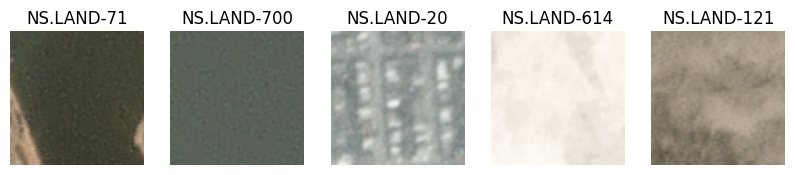

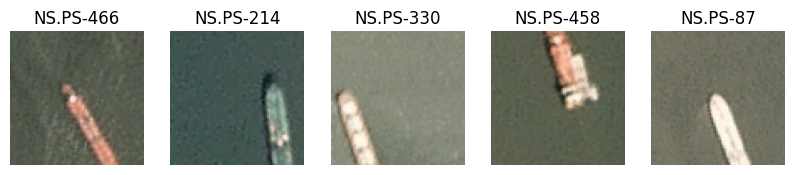

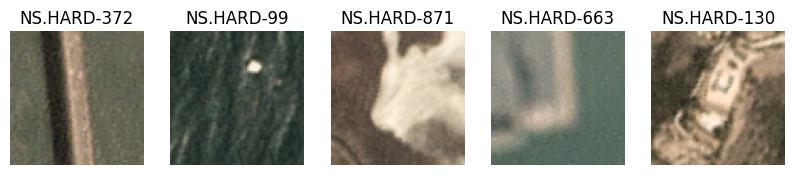

In [180]:
# Randomly view example data

for label in range(4):    
    X_select = X[y == label]
    disp = np.random.randint(size=5, low=0, high=X_select.shape[0])
    fig = plt.figure(figsize=(10, 10))
    
    for cell in range(5):
        fig.add_subplot(1, 5, cell + 1)
        plt.imshow(X_select[disp[cell]])
        plt.axis("off")
        plt.title(ID2LABEL[label] + "-" + str(disp[cell]))

# Applying Segmentation and Edge Detection

Experiments: <br />
1. Otsu segmentation
2. Canny edge detection
3. Laplacian edge detection

In [181]:
# Grayscale for utility

X_gray = np.array([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in X])

In [182]:
# Applying Otsu segmentation

X_otsu = np.array([cv.threshold(x, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1] for x in X_gray])
X_otsu.shape

(4000, 80, 80)

In [183]:
# Applying Canny edge detection

# Canny parameters
LOWER_BOUND = 170
UPPER_BOUND = 200

X_canny = np.array([cv.Canny(x, LOWER_BOUND, UPPER_BOUND) for x in X_gray])
X_canny.shape

(4000, 80, 80)

In [184]:
# Applying Laplacian edge detection

# Laplacian parameter
KERNEL_SIZE = 3

# Remove noise first with Gaussian filter
# X_lapl = np.array([cv.GaussianBlur(x, (5, 5), 5) for x in X_gray])

X_lapl = np.array([cv.medianBlur(x, 7) for x in X_gray])
X_lapl = np.array([cv.convertScaleAbs(cv.Laplacian(x, cv.CV_16S, KERNEL_SIZE)) for x in X_lapl])
# X_lapl = np.array([cv.GaussianBlur(x, (1, 1), 0) for x in X_lapl])
X_lapl.shape

(4000, 80, 80)

In [185]:
# Additonal: Applying Otsu + Laplacian edge detection

# Laplacian parameter
KERNEL_SIZE = 3

X_olapl = np.array([cv.convertScaleAbs(cv.Laplacian(x, cv.CV_16S, KERNEL_SIZE)) for x in X_otsu])
X_olapl.shape

(4000, 80, 80)

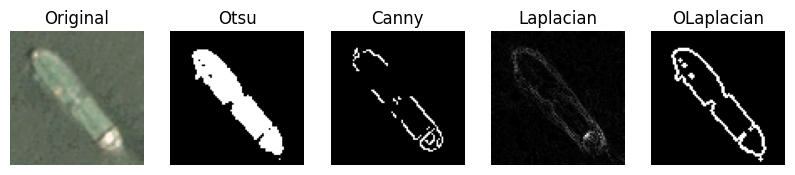

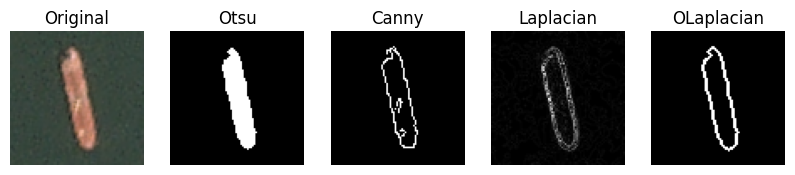

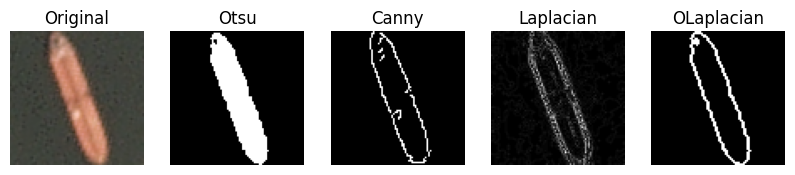

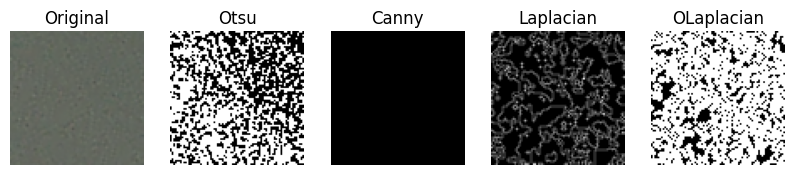

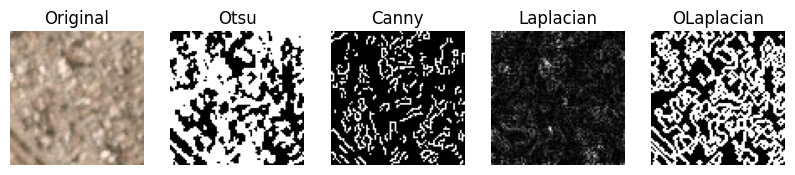

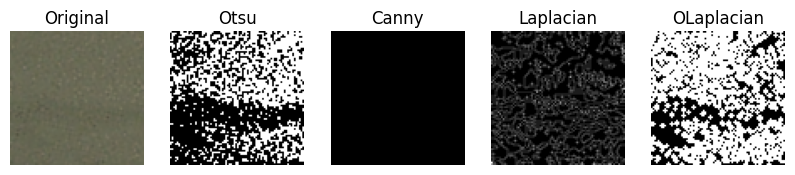

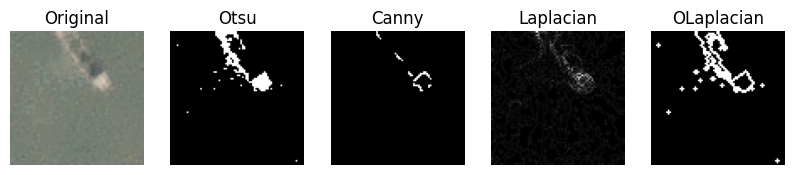

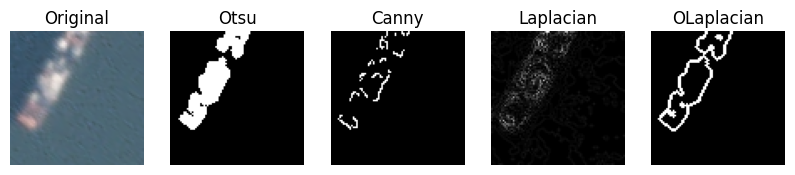

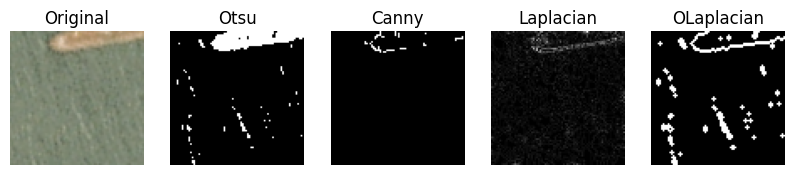

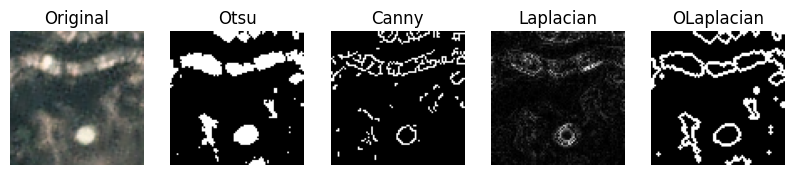

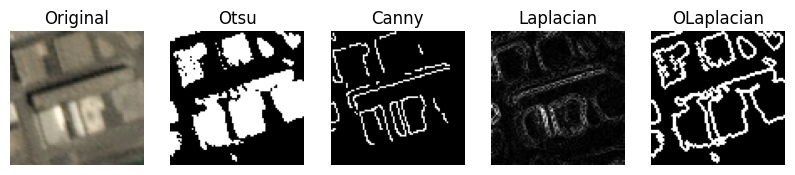

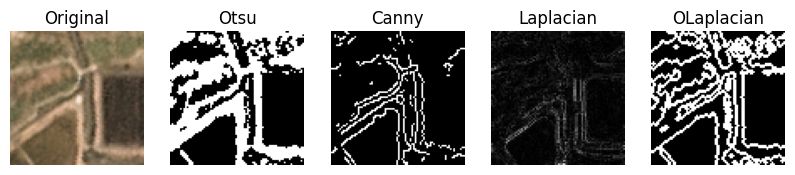

In [186]:
# Randomly view comparisons between preprocessing frameworks

for label in range(4):
    X_select = X[y == label]
    X_otsu_select = X_otsu[y == label]
    X_canny_select = X_canny[y == label]
    X_lapl_select = X_lapl[y == label]
    X_olapl_select = X_olapl[y == label]

    X_mapper = [X_select, X_otsu_select, X_canny_select, X_lapl_select, X_olapl_select]
    X_kind_mask = ["Original", "Otsu", "Canny", "Laplacian", "OLaplacian"]
    cmap_mapper = [None, "gray", "gray", "gray", "gray"]
    
    disp = np.random.randint(size=4, low=0, high=X_select.shape[0])
    for example in range(3):
        fig = plt.figure(figsize=(10, 10))
        for cell in range(5):
            fig.add_subplot(1, 5, cell + 1)
            plt.imshow(X_mapper[cell][disp[example]], cmap=cmap_mapper[cell])
            plt.axis("off")
            plt.title(X_kind_mask[cell])

# Training the XGBoost Model with Stratified K-Fold Cross Validation

In [187]:
# Define model

model = XGBClassifier(random_state=42, tree_method="hist", device=DEVICE)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [188]:
# Define SKFold Objectives

objectives = [
    {
        "name": "Original",
        "X": X,
        "reshaper": 80*80*3,
    },
    {
        "name": "Otsu",
        "X": X_otsu,
        "reshaper": 80*80,
    },
    {
        "name": "Laplacian",
        "X": X_lapl,
        "reshaper": 80*80,
    },
    {
        "name": "Canny",
        "X": X_canny,
        "reshaper": 80*80,
    },
    {
        "name": "OtsuLaplacian",
        "X": X_olapl,
        "reshaper": 80*80,
    },
]

fold = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [189]:
SUBSET = [x["name"] for x in objectives]
print(f"Will train: {SUBSET}")

Will train: ['Original', 'Otsu', 'Laplacian', 'Canny', 'OtsuLaplacian']


In [190]:
# Executing SKFold

for obj in objectives:
    if obj["name"] in SUBSET:

        print(f"Running: {obj['name']}")
        # Reshapping input array
        X_flat = obj["X"].reshape(-1, obj["reshaper"])
        # Running model fitting
        res = model_selection.cross_val_score(model, X_flat, y, cv=fold, scoring=metrics.make_scorer(metrics.f1_score, average="macro"))
        # Saving results 
        obj["result"] = res

Running: Original
Running: Otsu
Running: Laplacian
Running: Canny
Running: OtsuLaplacian


In [191]:
for obj in objectives:
    if obj["name"] not in SUBSET:

        print(f"Faking: {obj['name']}")
        obj["result"] = np.zeros(10)

In [192]:
# Printing the results

print('Preprocessing\tMean\tStd\tMin\tMax')

for obj in objectives:
    res = obj["result"]
    if obj["name"] in ["Otsu", "Canny"]:
        print(f'{obj["name"]}\t\t{res.mean():.4f}\t{res.std():.4f}\t{res.min():.4f}\t{res.max():.4f}')
    else:
        print(f'{obj["name"]}\t{res.mean():.4f}\t{res.std():.4f}\t{res.min():.4f}\t{res.max():.4f}')

Preprocessing	Mean	Std	Min	Max
Original	0.8661	0.0140	0.8416	0.8898
Otsu		0.8903	0.0158	0.8552	0.9125
Laplacian	0.8246	0.0153	0.7872	0.8408
Canny		0.6522	0.0188	0.6111	0.6833
OtsuLaplacian	0.7965	0.0234	0.7675	0.8328


In [193]:
boxplotter = {}
for obj in objectives:
    boxplotter[obj["name"]] = obj["result"]

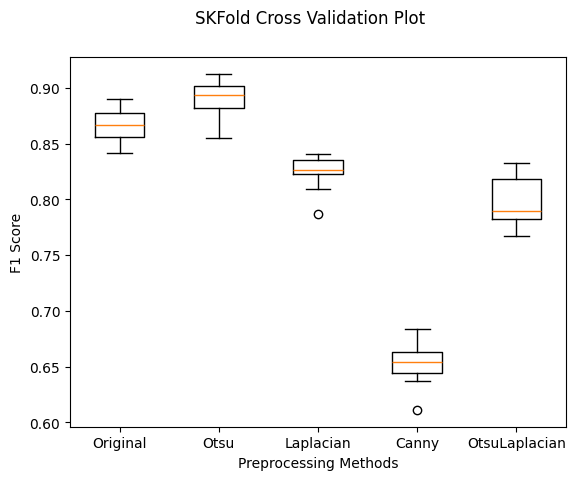

In [194]:
# Plotting the results

plot_wrapper = plt.figure()
plot_wrapper.suptitle("SKFold Cross Validation Plot")
sub = plot_wrapper.add_subplot()
plt.boxplot(list(boxplotter.values()))
sub.set_xticklabels(list(boxplotter.keys()))
plt.xlabel("Preprocessing Methods")
plt.ylabel("F1 Score")
plt.show()
